In [ ]:
import sqlite3
import pandas as pd
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from google.colab import drive
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, r2_score

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 시드 고정 코드
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [ ]:
# 데이터 로드 함수 정의 (데이터 전체 사용)
def load_data(db_path, year):
    with sqlite3.connect(db_path) as conn:
        df = pd.read_sql(f"SELECT * FROM '{year}'", conn)
    df = df.drop(columns=['저장시간']).select_dtypes(include=[np.number])
    df = df.interpolate(method='linear', limit_direction='both')  # 결측치 보간
    return df

In [ ]:
# 데이터셋 경로
db_paths = {
    "Iksan": "/content/drive/MyDrive/Tomato_db/Iksan.db",
    "Jeongeup": "/content/drive/MyDrive/Tomato_db/Jeongeup.db",
    "Sacheon_Kang": "/content/drive/MyDrive/Tomato_db/Sacheon_Kang.db",
    "Sacheon_Kim": "/content/drive/MyDrive/Tomato_db/Sacheon_Kim.db"
}

# 데이터 로드
data_sources = {
    "Iksan": {year: load_data(db_paths["Iksan"], year) for year in ['2018', '2019', '2020', '2021', '2022']},
    "Jeongeup": {year: load_data(db_paths["Jeongeup"], year) for year in ['2018', '2019', '2020', '2021', '2022']},
    "Sacheon_Kang": {year: load_data(db_paths["Sacheon_Kang"], year) for year in ['2018', '2019', '2020', '2021', '2022']},
    "Sacheon_Kim": {year: load_data(db_paths["Sacheon_Kim"], year) for year in ['2020', '2021', '2022']}
}

# 데이터 병합
train_data = pd.concat([
    data_sources["Iksan"]['2018'], data_sources["Iksan"]['2019'], data_sources["Iksan"]['2020'],
    data_sources["Jeongeup"]['2018'], data_sources["Jeongeup"]['2019'], data_sources["Jeongeup"]['2020'],
    data_sources["Sacheon_Kang"]['2018'], data_sources["Sacheon_Kang"]['2019'], data_sources["Sacheon_Kang"]['2020'],
    data_sources["Sacheon_Kim"]['2020']
], axis=0)

val_data = pd.concat([
    data_sources["Iksan"]['2021'], data_sources["Jeongeup"]['2021'], data_sources["Sacheon_Kang"]['2021'],
    data_sources["Sacheon_Kim"]['2021']
], axis=0)

test_data = pd.concat([
    data_sources["Iksan"]['2022'], data_sources["Jeongeup"]['2022'], data_sources["Sacheon_Kang"]['2022'],
    data_sources["Sacheon_Kim"]['2022']
], axis=0)


In [ ]:
# 데이터 스케일링 및 시퀀스 생성
def preprocess_data(df, scaler=None, fit_scaler=False, config=None):
    if fit_scaler:
        scaler = MinMaxScaler().fit(df[config["feature_columns"] + [config["target_column"]]])
    scaled = scaler.transform(df[config["feature_columns"] + [config["target_column"]]])

    x = np.array([scaled[i-config["sequence_length"]:i, :len(config["feature_columns"])]
                  for i in range(config["sequence_length"], len(scaled))])
    y = np.array([scaled[i, len(config["feature_columns"]):] for i in range(config["sequence_length"], len(scaled))])

    return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32), scaler

In [ ]:
# RNN 모델 정의
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, dropout_rate):
        super().__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_rate, nonlinearity='tanh')
        self.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, 12),
            nn.ReLU(),
            nn.Linear(12, output_size)
        )

    def forward(self, x):
        out, _ = self.rnn(x)
        return self.fc(out[:, -1, :])

# LSTM 모델 정의
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, dropout_rate):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_rate)
        self.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, 12),
            nn.ReLU(),
            nn.Linear(12, output_size)
        )

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

# GRU 모델 정의
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, dropout_rate):
        super().__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_rate)
        self.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, 12),
            nn.ReLU(),
            nn.Linear(12, output_size)
        )

    def forward(self, x):
        out, _ = self.gru(x)
        return self.fc(out[:, -1, :])

# 모델 선택 함수
def select_model(model_type, input_size, hidden_size, output_size, num_layers, dropout_rate):
    if model_type == "LSTM":
        return LSTMModel(input_size, hidden_size, output_size, num_layers, dropout_rate)
    elif model_type == "GRU":
        return GRUModel(input_size, hidden_size, output_size, num_layers, dropout_rate)
    elif model_type == "RNN":
        return RNNModel(input_size, hidden_size, output_size, num_layers, dropout_rate)
    else:
        raise ValueError("Invalid model type. Choose from 'LSTM', 'GRU', or 'RNN'.")

In [ ]:
# 모델 평가 함수
def evaluate_model(model, data_loader, device, criterion):
    model.eval()
    total_loss = 0.0
    predictions, actuals = [], []
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
            predictions.append(outputs.cpu().numpy())
            actuals.append(targets.cpu().numpy())

    predictions = np.concatenate(predictions, axis=0)
    actuals = np.concatenate(actuals, axis=0)

    rmse = np.sqrt(((predictions - actuals) ** 2).mean())
    r2 = 1 - ((predictions - actuals) ** 2).sum() / ((actuals - actuals.mean()) ** 2).sum()

    return total_loss / len(data_loader), rmse, r2

In [ ]:
config_baseline = {
    "sequence_length": 30,
    "batch_size": 1024,
    "hidden_size": 512,
    "num_layers": 1,
    "dropout_rate": 0,
    "learning_rate": 0.0001,
    "num_epochs": 100,
    "target_column": "내부온도",
    "feature_columns": ['내부온도', '외부온도', '풍향', '풍속', '일사량', '누적일사량', '감우'],
    "model_type": "LSTM"  # "LSTM", "GRU", "RNN" 중 하나 선택
}

In [ ]:
# 스케일러 설정 및 데이터 전처리
scaler_baseline = MinMaxScaler()
scaler_baseline.fit(pd.concat([train_data, val_data, test_data])[config_baseline["feature_columns"] + [config_baseline["target_column"]]])

x_train_baseline, y_train_baseline, _ = preprocess_data(train_data, scaler=scaler_baseline, fit_scaler=False, config=config_baseline)
x_val_baseline, y_val_baseline, _ = preprocess_data(val_data, scaler=scaler_baseline, fit_scaler=False, config=config_baseline)
x_test_baseline, y_test_baseline, _ = preprocess_data(test_data, scaler=scaler_baseline, fit_scaler=False, config=config_baseline)

# DataLoader 생성
train_loader_baseline = DataLoader(TensorDataset(x_train_baseline, y_train_baseline), batch_size=config_baseline["batch_size"], shuffle=True)
val_loader_baseline = DataLoader(TensorDataset(x_val_baseline, y_val_baseline), batch_size=config_baseline["batch_size"], shuffle=False)
test_loader_baseline = DataLoader(TensorDataset(x_test_baseline, y_test_baseline), batch_size=config_baseline["batch_size"], shuffle=False)

In [ ]:
# Baseline 모델 생성
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_baseline = select_model(
    model_type=config_baseline["model_type"],
    input_size=x_train_baseline.shape[2],
    hidden_size=config_baseline["hidden_size"],
    output_size=y_train_baseline.shape[1],
    num_layers=config_baseline["num_layers"],
    dropout_rate=config_baseline["dropout_rate"]
).to(device)

criterion = nn.MSELoss()
optimizer_baseline = optim.AdamW(model_baseline.parameters(), lr=config_baseline["learning_rate"])

In [ ]:
# Baseline 학습 및 검증
for epoch in range(config_baseline["num_epochs"]):
    model_baseline.train()
    running_loss = 0.0
    for inputs, targets in tqdm(train_loader_baseline, desc=f"Baseline Epoch {epoch + 1}/{config_baseline['num_epochs']}"):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer_baseline.zero_grad()
        loss = criterion(model_baseline(inputs), targets)
        loss.backward()
        optimizer_baseline.step()
        running_loss += loss.item()

    # 검증 단계
    model_baseline.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader_baseline:
            inputs, targets = inputs.to(device), targets.to(device)
            loss = criterion(model_baseline(inputs), targets)
            val_loss += loss.item()
    print(f"Epoch {epoch + 1}, Training Loss: {running_loss / len(train_loader_baseline):.7f}, Validation Loss: {val_loss / len(val_loader_baseline):.7f}")

Baseline Epoch 1/100: 100%|██████████| 4653/4653 [01:14<00:00, 62.80it/s]


Epoch 1, Training Loss: 0.0003091, Validation Loss: 0.0000218


Baseline Epoch 2/100: 100%|██████████| 4653/4653 [01:13<00:00, 63.29it/s]


Epoch 2, Training Loss: 0.0000176, Validation Loss: 0.0000125


Baseline Epoch 3/100: 100%|██████████| 4653/4653 [01:13<00:00, 63.44it/s]


Epoch 3, Training Loss: 0.0000094, Validation Loss: 0.0000070


Baseline Epoch 4/100: 100%|██████████| 4653/4653 [01:13<00:00, 63.53it/s]


Epoch 4, Training Loss: 0.0000068, Validation Loss: 0.0000051


Baseline Epoch 5/100: 100%|██████████| 4653/4653 [01:13<00:00, 63.10it/s]


Epoch 5, Training Loss: 0.0000055, Validation Loss: 0.0000076


Baseline Epoch 6/100: 100%|██████████| 4653/4653 [01:13<00:00, 63.08it/s]


Epoch 6, Training Loss: 0.0000049, Validation Loss: 0.0000076


Baseline Epoch 7/100: 100%|██████████| 4653/4653 [01:14<00:00, 62.88it/s]


Epoch 7, Training Loss: 0.0000045, Validation Loss: 0.0000037


Baseline Epoch 8/100: 100%|██████████| 4653/4653 [01:13<00:00, 62.99it/s]


Epoch 8, Training Loss: 0.0000042, Validation Loss: 0.0000045


Baseline Epoch 9/100: 100%|██████████| 4653/4653 [01:13<00:00, 62.94it/s]


Epoch 9, Training Loss: 0.0000040, Validation Loss: 0.0000038


Baseline Epoch 10/100: 100%|██████████| 4653/4653 [01:13<00:00, 63.06it/s]


Epoch 10, Training Loss: 0.0000039, Validation Loss: 0.0000033


Baseline Epoch 11/100: 100%|██████████| 4653/4653 [01:13<00:00, 62.89it/s]


Epoch 11, Training Loss: 0.0000039, Validation Loss: 0.0000066


Baseline Epoch 12/100: 100%|██████████| 4653/4653 [01:13<00:00, 62.98it/s]


Epoch 12, Training Loss: 0.0000038, Validation Loss: 0.0000036


Baseline Epoch 13/100: 100%|██████████| 4653/4653 [01:13<00:00, 62.93it/s]


Epoch 13, Training Loss: 0.0000038, Validation Loss: 0.0000042


Baseline Epoch 14/100: 100%|██████████| 4653/4653 [01:13<00:00, 63.11it/s]


Epoch 14, Training Loss: 0.0000037, Validation Loss: 0.0000034


Baseline Epoch 15/100: 100%|██████████| 4653/4653 [01:13<00:00, 62.97it/s]


Epoch 15, Training Loss: 0.0000037, Validation Loss: 0.0000034


Baseline Epoch 16/100: 100%|██████████| 4653/4653 [01:13<00:00, 63.08it/s]


Epoch 16, Training Loss: 0.0000037, Validation Loss: 0.0000033


Baseline Epoch 17/100: 100%|██████████| 4653/4653 [01:13<00:00, 63.12it/s]


Epoch 17, Training Loss: 0.0000037, Validation Loss: 0.0000033


Baseline Epoch 18/100: 100%|██████████| 4653/4653 [01:13<00:00, 63.23it/s]


Epoch 18, Training Loss: 0.0000037, Validation Loss: 0.0000032


Baseline Epoch 19/100: 100%|██████████| 4653/4653 [01:14<00:00, 62.66it/s]


Epoch 19, Training Loss: 0.0000037, Validation Loss: 0.0000037


Baseline Epoch 20/100: 100%|██████████| 4653/4653 [01:15<00:00, 61.85it/s]


Epoch 20, Training Loss: 0.0000036, Validation Loss: 0.0000033


Baseline Epoch 21/100: 100%|██████████| 4653/4653 [01:14<00:00, 62.14it/s]


Epoch 21, Training Loss: 0.0000036, Validation Loss: 0.0000032


Baseline Epoch 22/100: 100%|██████████| 4653/4653 [01:14<00:00, 62.42it/s]


Epoch 22, Training Loss: 0.0000036, Validation Loss: 0.0000032


Baseline Epoch 23/100: 100%|██████████| 4653/4653 [01:14<00:00, 62.58it/s]


Epoch 23, Training Loss: 0.0000036, Validation Loss: 0.0000033


Baseline Epoch 24/100: 100%|██████████| 4653/4653 [01:14<00:00, 62.66it/s]


Epoch 24, Training Loss: 0.0000036, Validation Loss: 0.0000034


Baseline Epoch 25/100: 100%|██████████| 4653/4653 [01:13<00:00, 62.94it/s]


Epoch 25, Training Loss: 0.0000036, Validation Loss: 0.0000033


Baseline Epoch 26/100: 100%|██████████| 4653/4653 [01:14<00:00, 62.69it/s]


Epoch 26, Training Loss: 0.0000036, Validation Loss: 0.0000032


Baseline Epoch 27/100: 100%|██████████| 4653/4653 [01:14<00:00, 62.57it/s]


Epoch 27, Training Loss: 0.0000036, Validation Loss: 0.0000032


Baseline Epoch 28/100: 100%|██████████| 4653/4653 [01:13<00:00, 63.00it/s]


Epoch 28, Training Loss: 0.0000035, Validation Loss: 0.0000032


Baseline Epoch 29/100: 100%|██████████| 4653/4653 [01:14<00:00, 62.82it/s]


Epoch 29, Training Loss: 0.0000035, Validation Loss: 0.0000032


Baseline Epoch 30/100: 100%|██████████| 4653/4653 [01:14<00:00, 62.72it/s]


Epoch 30, Training Loss: 0.0000035, Validation Loss: 0.0000033


Baseline Epoch 31/100: 100%|██████████| 4653/4653 [01:13<00:00, 62.98it/s]


Epoch 31, Training Loss: 0.0000035, Validation Loss: 0.0000037


Baseline Epoch 32/100: 100%|██████████| 4653/4653 [01:13<00:00, 63.07it/s]


Epoch 32, Training Loss: 0.0000035, Validation Loss: 0.0000032


Baseline Epoch 33/100: 100%|██████████| 4653/4653 [01:14<00:00, 62.88it/s]


Epoch 33, Training Loss: 0.0000035, Validation Loss: 0.0000033


Baseline Epoch 34/100: 100%|██████████| 4653/4653 [01:13<00:00, 62.95it/s]


Epoch 34, Training Loss: 0.0000035, Validation Loss: 0.0000031


Baseline Epoch 35/100: 100%|██████████| 4653/4653 [01:13<00:00, 63.02it/s]


Epoch 35, Training Loss: 0.0000035, Validation Loss: 0.0000032


Baseline Epoch 36/100: 100%|██████████| 4653/4653 [01:13<00:00, 63.44it/s]


Epoch 36, Training Loss: 0.0000035, Validation Loss: 0.0000034


Baseline Epoch 37/100: 100%|██████████| 4653/4653 [01:13<00:00, 63.45it/s]


Epoch 37, Training Loss: 0.0000035, Validation Loss: 0.0000032


Baseline Epoch 38/100: 100%|██████████| 4653/4653 [01:13<00:00, 63.65it/s]


Epoch 38, Training Loss: 0.0000035, Validation Loss: 0.0000035


Baseline Epoch 39/100: 100%|██████████| 4653/4653 [01:13<00:00, 63.64it/s]


Epoch 39, Training Loss: 0.0000035, Validation Loss: 0.0000033


Baseline Epoch 40/100: 100%|██████████| 4653/4653 [01:13<00:00, 63.35it/s]


Epoch 40, Training Loss: 0.0000035, Validation Loss: 0.0000031


Baseline Epoch 41/100: 100%|██████████| 4653/4653 [01:13<00:00, 62.93it/s]


Epoch 41, Training Loss: 0.0000035, Validation Loss: 0.0000035


Baseline Epoch 42/100: 100%|██████████| 4653/4653 [01:13<00:00, 63.28it/s]


Epoch 42, Training Loss: 0.0000034, Validation Loss: 0.0000032


Baseline Epoch 43/100: 100%|██████████| 4653/4653 [01:13<00:00, 63.27it/s]


Epoch 43, Training Loss: 0.0000035, Validation Loss: 0.0000038


Baseline Epoch 44/100: 100%|██████████| 4653/4653 [01:14<00:00, 62.85it/s]


Epoch 44, Training Loss: 0.0000034, Validation Loss: 0.0000032


Baseline Epoch 45/100: 100%|██████████| 4653/4653 [01:13<00:00, 62.91it/s]


Epoch 45, Training Loss: 0.0000034, Validation Loss: 0.0000033


Baseline Epoch 46/100: 100%|██████████| 4653/4653 [01:14<00:00, 62.67it/s]


Epoch 46, Training Loss: 0.0000034, Validation Loss: 0.0000033


Baseline Epoch 47/100: 100%|██████████| 4653/4653 [01:13<00:00, 62.92it/s]


Epoch 47, Training Loss: 0.0000034, Validation Loss: 0.0000032


Baseline Epoch 48/100: 100%|██████████| 4653/4653 [01:14<00:00, 62.23it/s]


Epoch 48, Training Loss: 0.0000034, Validation Loss: 0.0000033


Baseline Epoch 49/100: 100%|██████████| 4653/4653 [01:14<00:00, 62.13it/s]


Epoch 49, Training Loss: 0.0000034, Validation Loss: 0.0000031


Baseline Epoch 50/100: 100%|██████████| 4653/4653 [01:14<00:00, 62.26it/s]


Epoch 50, Training Loss: 0.0000034, Validation Loss: 0.0000031


Baseline Epoch 51/100: 100%|██████████| 4653/4653 [01:14<00:00, 62.46it/s]


Epoch 51, Training Loss: 0.0000034, Validation Loss: 0.0000031


Baseline Epoch 52/100: 100%|██████████| 4653/4653 [01:14<00:00, 62.38it/s]


Epoch 52, Training Loss: 0.0000034, Validation Loss: 0.0000032


Baseline Epoch 53/100: 100%|██████████| 4653/4653 [01:14<00:00, 62.17it/s]


Epoch 53, Training Loss: 0.0000034, Validation Loss: 0.0000033


Baseline Epoch 54/100: 100%|██████████| 4653/4653 [01:14<00:00, 62.67it/s]


Epoch 54, Training Loss: 0.0000034, Validation Loss: 0.0000031


Baseline Epoch 55/100: 100%|██████████| 4653/4653 [01:13<00:00, 62.96it/s]


Epoch 55, Training Loss: 0.0000034, Validation Loss: 0.0000031


Baseline Epoch 56/100: 100%|██████████| 4653/4653 [01:13<00:00, 62.94it/s]


Epoch 56, Training Loss: 0.0000034, Validation Loss: 0.0000031


Baseline Epoch 57/100: 100%|██████████| 4653/4653 [01:13<00:00, 62.92it/s]


Epoch 57, Training Loss: 0.0000034, Validation Loss: 0.0000035


Baseline Epoch 58/100: 100%|██████████| 4653/4653 [01:14<00:00, 62.48it/s]


Epoch 58, Training Loss: 0.0000034, Validation Loss: 0.0000035


Baseline Epoch 59/100: 100%|██████████| 4653/4653 [01:15<00:00, 61.88it/s]


Epoch 59, Training Loss: 0.0000034, Validation Loss: 0.0000031


Baseline Epoch 60/100: 100%|██████████| 4653/4653 [01:15<00:00, 61.97it/s]


Epoch 60, Training Loss: 0.0000034, Validation Loss: 0.0000032


Baseline Epoch 61/100: 100%|██████████| 4653/4653 [01:14<00:00, 62.81it/s]


Epoch 61, Training Loss: 0.0000034, Validation Loss: 0.0000031


Baseline Epoch 62/100: 100%|██████████| 4653/4653 [01:13<00:00, 63.06it/s]


Epoch 62, Training Loss: 0.0000034, Validation Loss: 0.0000032


Baseline Epoch 63/100: 100%|██████████| 4653/4653 [01:13<00:00, 62.90it/s]


Epoch 63, Training Loss: 0.0000034, Validation Loss: 0.0000031


Baseline Epoch 64/100: 100%|██████████| 4653/4653 [01:14<00:00, 62.70it/s]


Epoch 64, Training Loss: 0.0000033, Validation Loss: 0.0000032


Baseline Epoch 65/100: 100%|██████████| 4653/4653 [01:15<00:00, 61.99it/s]


Epoch 65, Training Loss: 0.0000033, Validation Loss: 0.0000031


Baseline Epoch 66/100: 100%|██████████| 4653/4653 [01:13<00:00, 62.97it/s]


Epoch 66, Training Loss: 0.0000033, Validation Loss: 0.0000031


Baseline Epoch 67/100: 100%|██████████| 4653/4653 [01:14<00:00, 62.52it/s]


Epoch 67, Training Loss: 0.0000034, Validation Loss: 0.0000033


Baseline Epoch 68/100: 100%|██████████| 4653/4653 [01:14<00:00, 62.29it/s]


Epoch 68, Training Loss: 0.0000033, Validation Loss: 0.0000031


Baseline Epoch 69/100: 100%|██████████| 4653/4653 [01:14<00:00, 62.18it/s]


Epoch 69, Training Loss: 0.0000033, Validation Loss: 0.0000031


Baseline Epoch 70/100: 100%|██████████| 4653/4653 [01:13<00:00, 63.23it/s]


Epoch 70, Training Loss: 0.0000033, Validation Loss: 0.0000031


Baseline Epoch 71/100: 100%|██████████| 4653/4653 [01:13<00:00, 63.02it/s]


Epoch 71, Training Loss: 0.0000033, Validation Loss: 0.0000031


Baseline Epoch 72/100: 100%|██████████| 4653/4653 [01:14<00:00, 62.49it/s]


Epoch 72, Training Loss: 0.0000033, Validation Loss: 0.0000031


Baseline Epoch 73/100: 100%|██████████| 4653/4653 [01:13<00:00, 62.88it/s]


Epoch 73, Training Loss: 0.0000033, Validation Loss: 0.0000032


Baseline Epoch 74/100: 100%|██████████| 4653/4653 [01:13<00:00, 63.34it/s]


Epoch 74, Training Loss: 0.0000033, Validation Loss: 0.0000031


Baseline Epoch 75/100: 100%|██████████| 4653/4653 [01:13<00:00, 63.29it/s]


Epoch 75, Training Loss: 0.0000033, Validation Loss: 0.0000031


Baseline Epoch 76/100: 100%|██████████| 4653/4653 [01:14<00:00, 62.59it/s]


Epoch 76, Training Loss: 0.0000033, Validation Loss: 0.0000031


Baseline Epoch 77/100: 100%|██████████| 4653/4653 [01:13<00:00, 63.48it/s]


Epoch 77, Training Loss: 0.0000033, Validation Loss: 0.0000033


Baseline Epoch 78/100: 100%|██████████| 4653/4653 [01:13<00:00, 63.59it/s]


Epoch 78, Training Loss: 0.0000033, Validation Loss: 0.0000031


Baseline Epoch 79/100: 100%|██████████| 4653/4653 [01:15<00:00, 61.83it/s]


Epoch 79, Training Loss: 0.0000033, Validation Loss: 0.0000031


Baseline Epoch 80/100: 100%|██████████| 4653/4653 [01:13<00:00, 63.59it/s]


Epoch 80, Training Loss: 0.0000033, Validation Loss: 0.0000031


Baseline Epoch 81/100: 100%|██████████| 4653/4653 [01:13<00:00, 63.28it/s]


Epoch 81, Training Loss: 0.0000033, Validation Loss: 0.0000031


Baseline Epoch 82/100: 100%|██████████| 4653/4653 [01:13<00:00, 63.52it/s]


Epoch 82, Training Loss: 0.0000033, Validation Loss: 0.0000032


Baseline Epoch 83/100: 100%|██████████| 4653/4653 [01:13<00:00, 63.52it/s]


Epoch 83, Training Loss: 0.0000033, Validation Loss: 0.0000031


Baseline Epoch 84/100: 100%|██████████| 4653/4653 [01:13<00:00, 63.53it/s]


Epoch 84, Training Loss: 0.0000033, Validation Loss: 0.0000032


Baseline Epoch 85/100: 100%|██████████| 4653/4653 [01:13<00:00, 63.48it/s]


Epoch 85, Training Loss: 0.0000033, Validation Loss: 0.0000031


Baseline Epoch 86/100: 100%|██████████| 4653/4653 [01:13<00:00, 63.28it/s]


Epoch 86, Training Loss: 0.0000033, Validation Loss: 0.0000031


Baseline Epoch 87/100: 100%|██████████| 4653/4653 [01:13<00:00, 63.56it/s]


Epoch 87, Training Loss: 0.0000033, Validation Loss: 0.0000031


Baseline Epoch 88/100: 100%|██████████| 4653/4653 [01:13<00:00, 63.45it/s]


Epoch 88, Training Loss: 0.0000033, Validation Loss: 0.0000032


Baseline Epoch 89/100: 100%|██████████| 4653/4653 [01:13<00:00, 63.42it/s]


Epoch 89, Training Loss: 0.0000033, Validation Loss: 0.0000031


Baseline Epoch 90/100: 100%|██████████| 4653/4653 [01:13<00:00, 63.39it/s]


Epoch 90, Training Loss: 0.0000033, Validation Loss: 0.0000033


Baseline Epoch 91/100: 100%|██████████| 4653/4653 [01:13<00:00, 63.63it/s]


Epoch 91, Training Loss: 0.0000033, Validation Loss: 0.0000031


Baseline Epoch 92/100: 100%|██████████| 4653/4653 [01:14<00:00, 62.85it/s]


Epoch 92, Training Loss: 0.0000033, Validation Loss: 0.0000031


Baseline Epoch 93/100: 100%|██████████| 4653/4653 [01:14<00:00, 62.84it/s]


Epoch 93, Training Loss: 0.0000033, Validation Loss: 0.0000032


Baseline Epoch 94/100: 100%|██████████| 4653/4653 [01:14<00:00, 62.72it/s]


Epoch 94, Training Loss: 0.0000033, Validation Loss: 0.0000032


Baseline Epoch 95/100: 100%|██████████| 4653/4653 [01:13<00:00, 63.21it/s]


Epoch 95, Training Loss: 0.0000033, Validation Loss: 0.0000031


Baseline Epoch 96/100: 100%|██████████| 4653/4653 [01:13<00:00, 63.38it/s]


Epoch 96, Training Loss: 0.0000033, Validation Loss: 0.0000034


Baseline Epoch 97/100: 100%|██████████| 4653/4653 [01:13<00:00, 63.34it/s]


Epoch 97, Training Loss: 0.0000033, Validation Loss: 0.0000031


Baseline Epoch 98/100: 100%|██████████| 4653/4653 [01:13<00:00, 63.38it/s]


Epoch 98, Training Loss: 0.0000033, Validation Loss: 0.0000031


Baseline Epoch 99/100: 100%|██████████| 4653/4653 [01:13<00:00, 63.21it/s]


Epoch 99, Training Loss: 0.0000033, Validation Loss: 0.0000031


Baseline Epoch 100/100: 100%|██████████| 4653/4653 [01:13<00:00, 63.43it/s]


Epoch 100, Training Loss: 0.0000033, Validation Loss: 0.0000030


In [ ]:
# Baseline 예측값 생성
def predict_internal_temperature(model, data_loader, device):
    model.eval()
    predictions = []
    with torch.no_grad():
        for inputs, _ in data_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            predictions.append(outputs.cpu().numpy())
    return np.concatenate(predictions, axis=0)

# 기존 모델로 내부온도 예측
predicted_temp_train = predict_internal_temperature(model_baseline, train_loader_baseline, device)
predicted_temp_val = predict_internal_temperature(model_baseline, val_loader_baseline, device)

print(f"Number of predicted values for training data: {len(predicted_temp_train)}")
print(f"Number of predicted values for validation data: {len(predicted_temp_val)}")

Number of predicted values for training data: 4764412
Number of predicted values for validation data: 2089579


In [ ]:
# 훈련 예측값의 상위 10개 출력 (정규화 O)
print("Predicted values for training data :")
print(predicted_temp_train[:10])

Predicted values for training data :
[[0.3840378 ]
 [0.22580732]
 [0.26956695]
 [0.37633896]
 [0.40213168]
 [0.6226708 ]
 [0.30637777]
 [0.27156958]
 [0.34154496]
 [0.2686753 ]]


In [ ]:
# 역정규화 함수
def inverse_transform_predictions(predictions, scaler, feature_columns_with_target):
    # 스케일러가 학습한 전체 feature 개수에 맞게 차원 확장
    padded_predictions = np.hstack([
        predictions,
        np.zeros((predictions.shape[0], len(feature_columns_with_target) - 1))
    ])
    # 역정규화 수행
    original_values = scaler.inverse_transform(padded_predictions)
    return original_values[:, 0]  # 내부온도 값만 반환

# 역정규화된 예측값 생성 (np.round로 소숫점 반올림)
feature_columns_with_target = config_baseline["feature_columns"] + [config_baseline["target_column"]]
predicted_temp_train_original = np.round(
    inverse_transform_predictions(predicted_temp_train.reshape(-1, 1), scaler_baseline, feature_columns_with_target),
    1
)
predicted_temp_val_original = np.round(
    inverse_transform_predictions(predicted_temp_val.reshape(-1, 1), scaler_baseline, feature_columns_with_target),
    1
)

# 예측 값을 원본 데이터프레임에 추가 (시퀀스 길이 고려)
sequence_length = config_baseline["sequence_length"]

train_data_with_predictions = train_data.iloc[sequence_length:].copy()
train_data_with_predictions['내부온도'] = predicted_temp_train_original  # 역정규화된 값 추가

val_data_with_predictions = val_data.iloc[sequence_length:].copy()
val_data_with_predictions['내부온도'] = predicted_temp_val_original  # 역정규화된 값 추가

print(f"Number of predicted values for training data: {len(train_data_with_predictions)}")
print(f"Number of predicted values for validation data: {len(val_data_with_predictions)}")

Number of predicted values for training data: 4764412
Number of predicted values for validation data: 2089579


In [ ]:
# 확인용 출력
print("Train data with predictions (Top 10):")
print(train_data_with_predictions.head(10))

Train data with predictions (Top 10):
    내부온도  내부온도1  내부온도2  내부온도3  내부습도  내부습도1  내부습도2  내부습도3   지온   지습  ...  \
30  23.2   13.2   14.0   30.8  85.7   82.2   89.2   64.2  0.0  0.0  ...   
31  13.6   13.2   14.0   28.6  85.7   81.9   89.5   98.7  0.0  0.0  ...   
32  16.3   13.3   14.1   31.4  85.2   81.3   89.1  100.0  0.0  0.0  ...   
33  22.7   13.3   14.1   34.6  84.9   81.2   88.6  100.0  0.0  0.0  ...   
34  24.2   13.4   14.1   37.9  84.8   81.0   88.5  100.0  0.0  0.0  ...   
35  37.5   13.4   14.1   41.5  84.8   81.0   88.5  100.0  0.0  0.0  ...   
36  18.5   13.4   14.1   45.1  85.1   81.6   88.5  100.0  0.0  0.0  ...   
37  16.4   13.5   14.1   49.3  84.8   81.1   88.5  100.0  0.0  0.0  ...   
38  20.6   13.5   14.1   53.7  84.8   81.1   88.5  100.0  0.0  0.0  ...   
39  16.2   13.6   14.1   52.2  84.5   80.5   88.5   55.8  0.0  0.0  ...   

    공급온도2  정전신호  로그인상태  회수온도1  회수온도2  EC1  EC2  PH1  PH2  내부일사  
30    0.0     1      1    0.0      0  0.0  1.5  0.0  0.0     0  
31    

In [ ]:
# 역정규화 함수
def inverse_transform(scaler, data, feature_columns_with_target):
    """
    데이터 역정규화 함수
    :param scaler: MinMaxScaler 객체
    :param data: 정규화된 데이터 (numpy 배열)
    :param feature_columns_with_target: feature와 target column 이름을 포함한 리스트
    :return: target column의 역정규화된 값
    """
    # 예측 데이터와 동일한 차원을 가진 빈 배열 생성
    full_data = np.zeros((data.shape[0], len(feature_columns_with_target)))
    full_data[:, -1] = data.squeeze()  # target column 위치에만 데이터 할당
    inversed = scaler.inverse_transform(full_data)  # 역정규화
    return inversed[:, -1]  # target column만 반환

# 2022년도 테스트 데이터 예측 및 역정규화
model_baseline.eval()  # 모델을 평가 모드로 전환
predictions = []
actuals = []

with torch.no_grad():
    for inputs, targets in test_loader_baseline:
        inputs = inputs.to(device)
        output = model_baseline(inputs).cpu().numpy()  # 모델 출력
        predictions.append(output)
        actuals.append(targets.cpu().numpy())

# 예측값과 실제값 배열로 변환
predictions = np.concatenate(predictions, axis=0)  # 리스트를 배열로 변환
actuals = np.concatenate(actuals, axis=0)

# 역정규화
feature_columns_with_target = config_baseline["feature_columns"] + [config_baseline["target_column"]]
predictions_inverse = inverse_transform(scaler_baseline, predictions, feature_columns_with_target)
actuals_inverse = inverse_transform(scaler_baseline, actuals, feature_columns_with_target)

# RMSE 및 R² 계산
rmse = np.sqrt(mean_squared_error(actuals_inverse, predictions_inverse))
r2 = r2_score(actuals_inverse, predictions_inverse)

print(f"2022년 데이터에 대한 역정규화된 RMSE: {rmse:.4f}")
print(f"2022년 데이터에 대한 역정규화된 R²: {r2:.4f}")


2022년 데이터에 대한 역정규화된 RMSE: 0.1248
2022년 데이터에 대한 역정규화된 R²: 0.9996


In [ ]:
# FineTuning 설정값
config_finetuning = {
    "sequence_length": 30,
    "batch_size": 1024,
    "hidden_size": 512,
    "num_layers": 1,
    "dropout_rate": 0,
    "learning_rate": 0.0001,
    "num_epochs": 100,
    "feature_columns": ['내부온도', '공급온도1', '천창좌개도', '천창우개도', '커튼상개도', '커튼하개도',
                        '측커튼개도', '외부커튼개도', '3Way밸브1개도', '3Way밸브2개도'],
    "target_column": ['공급온도1', '천창좌개도', '천창우개도', '커튼상개도', '커튼하개도',
                        '측커튼개도', '외부커튼개도', '3Way밸브1개도', '3Way밸브2개도'],
    "model_type": "LSTM"  # "LSTM", "GRU", "RNN" 중 하나 선택
}

In [ ]:
def preprocess_data(df, scaler=None, fit_scaler=False, config=None):
    # feature_columns와 target_column이 리스트 형태인지 확인
    feature_columns = config["feature_columns"]
    target_columns = config["target_column"]

    # 스케일러 학습
    if fit_scaler:
        scaler = MinMaxScaler().fit(df[feature_columns + target_columns])

    # 스케일링
    scaled = scaler.transform(df[feature_columns + target_columns])

    # 시퀀스 데이터 생성
    x = np.array([scaled[i - config["sequence_length"]:i, :len(feature_columns)]
                  for i in range(config["sequence_length"], len(scaled))])
    y = np.array([scaled[i, len(feature_columns):] for i in range(config["sequence_length"], len(scaled))])

    return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32), scaler

In [ ]:
# Fine-tuning 스케일러 학습
finetuning_scaler = MinMaxScaler()
finetuning_scaler.fit(train_data_with_predictions[config_finetuning["feature_columns"] + config_finetuning["target_column"]])

# Fine-tuning 데이터 준비
x_train_finetuning, y_train_finetuning, _ = preprocess_data(
    train_data_with_predictions,
    scaler=finetuning_scaler,
    fit_scaler=False,
    config=config_finetuning
)

x_val_finetuning, y_val_finetuning, _ = preprocess_data(
    val_data_with_predictions,
    scaler=finetuning_scaler,
    fit_scaler=False,
    config=config_finetuning
)

# Fine-tuning DataLoader 생성
train_loader_finetuning = DataLoader(TensorDataset(x_train_finetuning, y_train_finetuning), batch_size=config_finetuning["batch_size"], shuffle=False)
val_loader_finetuning = DataLoader(TensorDataset(x_val_finetuning, y_val_finetuning), batch_size=config_finetuning["batch_size"], shuffle=False)

In [ ]:
model_finetuning = select_model(
    model_type=config_finetuning["model_type"],
    input_size=len(config_finetuning["feature_columns"]),
    hidden_size=config_finetuning["hidden_size"],
    output_size=len(config_finetuning["target_column"]),
    num_layers=config_finetuning["num_layers"],
    dropout_rate=config_finetuning["dropout_rate"]
).to(device)

optimizer_finetuning = optim.AdamW(model_finetuning.parameters(), lr=config_finetuning["learning_rate"])

FineTuning Epoch 1/100: 100%|██████████| 4653/4653 [01:10<00:00, 65.99it/s]


Epoch 1, Training Loss: 0.04642, Validation Loss: 0.07235


FineTuning Epoch 2/100: 100%|██████████| 4653/4653 [01:10<00:00, 66.17it/s]


Epoch 2, Training Loss: 0.01350, Validation Loss: 0.04583


FineTuning Epoch 3/100: 100%|██████████| 4653/4653 [01:10<00:00, 66.30it/s]


Epoch 3, Training Loss: 0.00382, Validation Loss: 0.01164


FineTuning Epoch 4/100: 100%|██████████| 4653/4653 [01:10<00:00, 66.32it/s]


Epoch 4, Training Loss: 0.00208, Validation Loss: 0.00866


FineTuning Epoch 5/100: 100%|██████████| 4653/4653 [01:10<00:00, 65.95it/s]


Epoch 5, Training Loss: 0.00157, Validation Loss: 0.00624


FineTuning Epoch 6/100: 100%|██████████| 4653/4653 [01:10<00:00, 65.89it/s]


Epoch 6, Training Loss: 0.00133, Validation Loss: 0.00377


FineTuning Epoch 7/100: 100%|██████████| 4653/4653 [01:10<00:00, 65.86it/s]


Epoch 7, Training Loss: 0.00114, Validation Loss: 0.00295


FineTuning Epoch 8/100: 100%|██████████| 4653/4653 [01:10<00:00, 66.08it/s]


Epoch 8, Training Loss: 0.00090, Validation Loss: 0.00230


FineTuning Epoch 9/100: 100%|██████████| 4653/4653 [01:10<00:00, 65.93it/s]


Epoch 9, Training Loss: 0.00074, Validation Loss: 0.00201


FineTuning Epoch 10/100: 100%|██████████| 4653/4653 [01:10<00:00, 65.85it/s]


Epoch 10, Training Loss: 0.00069, Validation Loss: 0.00206


FineTuning Epoch 11/100: 100%|██████████| 4653/4653 [01:10<00:00, 65.79it/s]


Epoch 11, Training Loss: 0.00066, Validation Loss: 0.00185


FineTuning Epoch 12/100: 100%|██████████| 4653/4653 [01:10<00:00, 65.76it/s]


Epoch 12, Training Loss: 0.00064, Validation Loss: 0.00165


FineTuning Epoch 13/100: 100%|██████████| 4653/4653 [01:10<00:00, 66.00it/s]


Epoch 13, Training Loss: 0.00062, Validation Loss: 0.00149


FineTuning Epoch 14/100: 100%|██████████| 4653/4653 [01:10<00:00, 65.73it/s]


Epoch 14, Training Loss: 0.00061, Validation Loss: 0.00126


FineTuning Epoch 15/100: 100%|██████████| 4653/4653 [01:10<00:00, 65.59it/s]


Epoch 15, Training Loss: 0.00060, Validation Loss: 0.00119


FineTuning Epoch 16/100: 100%|██████████| 4653/4653 [01:10<00:00, 66.02it/s]


Epoch 16, Training Loss: 0.00060, Validation Loss: 0.00143


FineTuning Epoch 17/100: 100%|██████████| 4653/4653 [01:10<00:00, 65.79it/s]


Epoch 17, Training Loss: 0.00059, Validation Loss: 0.00129


FineTuning Epoch 18/100: 100%|██████████| 4653/4653 [01:10<00:00, 65.77it/s]


Epoch 18, Training Loss: 0.00058, Validation Loss: 0.00128


FineTuning Epoch 19/100: 100%|██████████| 4653/4653 [01:10<00:00, 65.72it/s]


Epoch 19, Training Loss: 0.00058, Validation Loss: 0.00133


FineTuning Epoch 20/100: 100%|██████████| 4653/4653 [01:11<00:00, 65.34it/s]


Epoch 20, Training Loss: 0.00057, Validation Loss: 0.00137


FineTuning Epoch 21/100: 100%|██████████| 4653/4653 [01:10<00:00, 65.66it/s]


Epoch 21, Training Loss: 0.00056, Validation Loss: 0.00142


FineTuning Epoch 22/100: 100%|██████████| 4653/4653 [01:10<00:00, 65.85it/s]


Epoch 22, Training Loss: 0.00056, Validation Loss: 0.00139


FineTuning Epoch 23/100: 100%|██████████| 4653/4653 [01:10<00:00, 65.77it/s]


Epoch 23, Training Loss: 0.00055, Validation Loss: 0.00134


FineTuning Epoch 24/100: 100%|██████████| 4653/4653 [01:10<00:00, 65.55it/s]


Epoch 24, Training Loss: 0.00055, Validation Loss: 0.00127


FineTuning Epoch 25/100: 100%|██████████| 4653/4653 [01:10<00:00, 65.76it/s]


Epoch 25, Training Loss: 0.00054, Validation Loss: 0.00120


FineTuning Epoch 26/100: 100%|██████████| 4653/4653 [01:10<00:00, 65.85it/s]


Epoch 26, Training Loss: 0.00054, Validation Loss: 0.00113


FineTuning Epoch 27/100: 100%|██████████| 4653/4653 [01:10<00:00, 65.83it/s]


Epoch 27, Training Loss: 0.00054, Validation Loss: 0.00104


FineTuning Epoch 28/100: 100%|██████████| 4653/4653 [01:10<00:00, 65.77it/s]


Epoch 28, Training Loss: 0.00053, Validation Loss: 0.00101


FineTuning Epoch 29/100: 100%|██████████| 4653/4653 [01:10<00:00, 65.90it/s]


Epoch 29, Training Loss: 0.00053, Validation Loss: 0.00099


FineTuning Epoch 30/100: 100%|██████████| 4653/4653 [01:10<00:00, 65.78it/s]


Epoch 30, Training Loss: 0.00053, Validation Loss: 0.00096


FineTuning Epoch 31/100: 100%|██████████| 4653/4653 [01:11<00:00, 65.41it/s]


Epoch 31, Training Loss: 0.00052, Validation Loss: 0.00093


FineTuning Epoch 32/100: 100%|██████████| 4653/4653 [01:11<00:00, 64.94it/s]


Epoch 32, Training Loss: 0.00052, Validation Loss: 0.00091


FineTuning Epoch 33/100: 100%|██████████| 4653/4653 [01:14<00:00, 62.71it/s]


Epoch 33, Training Loss: 0.00052, Validation Loss: 0.00089


FineTuning Epoch 34/100: 100%|██████████| 4653/4653 [01:14<00:00, 62.34it/s]


Epoch 34, Training Loss: 0.00052, Validation Loss: 0.00088


FineTuning Epoch 35/100: 100%|██████████| 4653/4653 [01:14<00:00, 62.29it/s]


Epoch 35, Training Loss: 0.00051, Validation Loss: 0.00085


FineTuning Epoch 36/100: 100%|██████████| 4653/4653 [01:14<00:00, 62.66it/s]


Epoch 36, Training Loss: 0.00051, Validation Loss: 0.00082


FineTuning Epoch 37/100: 100%|██████████| 4653/4653 [01:14<00:00, 62.59it/s]


Epoch 37, Training Loss: 0.00051, Validation Loss: 0.00080


FineTuning Epoch 38/100: 100%|██████████| 4653/4653 [01:11<00:00, 64.91it/s]


Epoch 38, Training Loss: 0.00051, Validation Loss: 0.00077


FineTuning Epoch 39/100: 100%|██████████| 4653/4653 [01:11<00:00, 65.51it/s]


Epoch 39, Training Loss: 0.00051, Validation Loss: 0.00076


FineTuning Epoch 40/100: 100%|██████████| 4653/4653 [01:11<00:00, 65.27it/s]


Epoch 40, Training Loss: 0.00050, Validation Loss: 0.00074


FineTuning Epoch 41/100: 100%|██████████| 4653/4653 [01:10<00:00, 65.66it/s]


Epoch 41, Training Loss: 0.00050, Validation Loss: 0.00075


FineTuning Epoch 42/100: 100%|██████████| 4653/4653 [01:10<00:00, 65.88it/s]


Epoch 42, Training Loss: 0.00050, Validation Loss: 0.00075


FineTuning Epoch 43/100: 100%|██████████| 4653/4653 [01:10<00:00, 65.71it/s]


Epoch 43, Training Loss: 0.00050, Validation Loss: 0.00073


FineTuning Epoch 44/100: 100%|██████████| 4653/4653 [01:11<00:00, 65.30it/s]


Epoch 44, Training Loss: 0.00050, Validation Loss: 0.00073


FineTuning Epoch 45/100: 100%|██████████| 4653/4653 [01:10<00:00, 65.70it/s]


Epoch 45, Training Loss: 0.00050, Validation Loss: 0.00073


FineTuning Epoch 46/100: 100%|██████████| 4653/4653 [01:11<00:00, 65.25it/s]


Epoch 46, Training Loss: 0.00050, Validation Loss: 0.00072


FineTuning Epoch 47/100: 100%|██████████| 4653/4653 [01:10<00:00, 65.96it/s]


Epoch 47, Training Loss: 0.00049, Validation Loss: 0.00070


FineTuning Epoch 48/100: 100%|██████████| 4653/4653 [01:10<00:00, 65.89it/s]


Epoch 48, Training Loss: 0.00049, Validation Loss: 0.00070


FineTuning Epoch 49/100: 100%|██████████| 4653/4653 [01:10<00:00, 66.10it/s]


Epoch 49, Training Loss: 0.00049, Validation Loss: 0.00070


FineTuning Epoch 50/100: 100%|██████████| 4653/4653 [01:10<00:00, 65.84it/s]


Epoch 50, Training Loss: 0.00049, Validation Loss: 0.00068


FineTuning Epoch 51/100: 100%|██████████| 4653/4653 [01:10<00:00, 66.01it/s]


Epoch 51, Training Loss: 0.00049, Validation Loss: 0.00068


FineTuning Epoch 52/100: 100%|██████████| 4653/4653 [01:10<00:00, 65.88it/s]


Epoch 52, Training Loss: 0.00049, Validation Loss: 0.00068


FineTuning Epoch 53/100: 100%|██████████| 4653/4653 [01:10<00:00, 65.95it/s]


Epoch 53, Training Loss: 0.00049, Validation Loss: 0.00069


FineTuning Epoch 54/100: 100%|██████████| 4653/4653 [01:13<00:00, 63.08it/s]


Epoch 54, Training Loss: 0.00048, Validation Loss: 0.00068


FineTuning Epoch 55/100: 100%|██████████| 4653/4653 [01:13<00:00, 62.92it/s]


Epoch 55, Training Loss: 0.00048, Validation Loss: 0.00068


FineTuning Epoch 56/100: 100%|██████████| 4653/4653 [01:14<00:00, 62.63it/s]


Epoch 56, Training Loss: 0.00048, Validation Loss: 0.00067


FineTuning Epoch 57/100: 100%|██████████| 4653/4653 [01:14<00:00, 62.47it/s]


Epoch 57, Training Loss: 0.00048, Validation Loss: 0.00068


FineTuning Epoch 58/100: 100%|██████████| 4653/4653 [01:14<00:00, 62.46it/s]


Epoch 58, Training Loss: 0.00048, Validation Loss: 0.00069


FineTuning Epoch 59/100: 100%|██████████| 4653/4653 [01:14<00:00, 62.83it/s]


Epoch 59, Training Loss: 0.00048, Validation Loss: 0.00071


FineTuning Epoch 60/100: 100%|██████████| 4653/4653 [01:10<00:00, 65.65it/s]


Epoch 60, Training Loss: 0.00048, Validation Loss: 0.00068


FineTuning Epoch 61/100: 100%|██████████| 4653/4653 [01:10<00:00, 65.94it/s]


Epoch 61, Training Loss: 0.00048, Validation Loss: 0.00069


FineTuning Epoch 62/100: 100%|██████████| 4653/4653 [01:10<00:00, 66.12it/s]


Epoch 62, Training Loss: 0.00048, Validation Loss: 0.00069


FineTuning Epoch 63/100: 100%|██████████| 4653/4653 [01:10<00:00, 65.76it/s]


Epoch 63, Training Loss: 0.00048, Validation Loss: 0.00070


FineTuning Epoch 64/100: 100%|██████████| 4653/4653 [01:10<00:00, 65.57it/s]


Epoch 64, Training Loss: 0.00047, Validation Loss: 0.00071


FineTuning Epoch 65/100: 100%|██████████| 4653/4653 [01:11<00:00, 65.25it/s]


Epoch 65, Training Loss: 0.00047, Validation Loss: 0.00069


FineTuning Epoch 66/100: 100%|██████████| 4653/4653 [01:10<00:00, 65.88it/s]


Epoch 66, Training Loss: 0.00047, Validation Loss: 0.00072


FineTuning Epoch 67/100: 100%|██████████| 4653/4653 [01:10<00:00, 65.94it/s]


Epoch 67, Training Loss: 0.00047, Validation Loss: 0.00070


FineTuning Epoch 68/100: 100%|██████████| 4653/4653 [01:10<00:00, 66.08it/s]


Epoch 68, Training Loss: 0.00047, Validation Loss: 0.00070


FineTuning Epoch 69/100: 100%|██████████| 4653/4653 [01:09<00:00, 66.55it/s]


Epoch 69, Training Loss: 0.00047, Validation Loss: 0.00073


FineTuning Epoch 70/100: 100%|██████████| 4653/4653 [01:10<00:00, 66.31it/s]


Epoch 70, Training Loss: 0.00047, Validation Loss: 0.00073


FineTuning Epoch 71/100: 100%|██████████| 4653/4653 [01:10<00:00, 66.18it/s]


Epoch 71, Training Loss: 0.00047, Validation Loss: 0.00078


FineTuning Epoch 72/100: 100%|██████████| 4653/4653 [01:10<00:00, 65.90it/s]


Epoch 72, Training Loss: 0.00047, Validation Loss: 0.00069


FineTuning Epoch 73/100: 100%|██████████| 4653/4653 [01:11<00:00, 65.51it/s]


Epoch 73, Training Loss: 0.00047, Validation Loss: 0.00073


FineTuning Epoch 74/100: 100%|██████████| 4653/4653 [01:10<00:00, 66.04it/s]


Epoch 74, Training Loss: 0.00046, Validation Loss: 0.00076


FineTuning Epoch 75/100: 100%|██████████| 4653/4653 [01:10<00:00, 66.14it/s]


Epoch 75, Training Loss: 0.00046, Validation Loss: 0.00073


FineTuning Epoch 76/100: 100%|██████████| 4653/4653 [01:10<00:00, 66.31it/s]


Epoch 76, Training Loss: 0.00046, Validation Loss: 0.00077


FineTuning Epoch 77/100: 100%|██████████| 4653/4653 [01:10<00:00, 65.79it/s]


Epoch 77, Training Loss: 0.00046, Validation Loss: 0.00072


FineTuning Epoch 78/100: 100%|██████████| 4653/4653 [01:10<00:00, 66.37it/s]


Epoch 78, Training Loss: 0.00046, Validation Loss: 0.00073


FineTuning Epoch 79/100: 100%|██████████| 4653/4653 [01:11<00:00, 65.37it/s]


Epoch 79, Training Loss: 0.00046, Validation Loss: 0.00074


FineTuning Epoch 80/100: 100%|██████████| 4653/4653 [01:10<00:00, 66.00it/s]


Epoch 80, Training Loss: 0.00046, Validation Loss: 0.00070


FineTuning Epoch 81/100: 100%|██████████| 4653/4653 [01:10<00:00, 65.87it/s]


Epoch 81, Training Loss: 0.00046, Validation Loss: 0.00069


FineTuning Epoch 82/100: 100%|██████████| 4653/4653 [01:11<00:00, 65.53it/s]


Epoch 82, Training Loss: 0.00046, Validation Loss: 0.00070


FineTuning Epoch 83/100: 100%|██████████| 4653/4653 [01:10<00:00, 66.00it/s]


Epoch 83, Training Loss: 0.00046, Validation Loss: 0.00071


FineTuning Epoch 84/100: 100%|██████████| 4653/4653 [01:10<00:00, 65.88it/s]


Epoch 84, Training Loss: 0.00046, Validation Loss: 0.00072


FineTuning Epoch 85/100: 100%|██████████| 4653/4653 [01:10<00:00, 66.03it/s]


Epoch 85, Training Loss: 0.00045, Validation Loss: 0.00073


FineTuning Epoch 86/100: 100%|██████████| 4653/4653 [01:10<00:00, 65.76it/s]


Epoch 86, Training Loss: 0.00045, Validation Loss: 0.00071


FineTuning Epoch 87/100: 100%|██████████| 4653/4653 [01:11<00:00, 65.36it/s]


Epoch 87, Training Loss: 0.00045, Validation Loss: 0.00071


FineTuning Epoch 88/100: 100%|██████████| 4653/4653 [01:11<00:00, 65.05it/s]


Epoch 88, Training Loss: 0.00045, Validation Loss: 0.00076


FineTuning Epoch 89/100: 100%|██████████| 4653/4653 [01:11<00:00, 65.49it/s]


Epoch 89, Training Loss: 0.00045, Validation Loss: 0.00074


FineTuning Epoch 90/100: 100%|██████████| 4653/4653 [01:10<00:00, 65.79it/s]


Epoch 90, Training Loss: 0.00045, Validation Loss: 0.00073


FineTuning Epoch 91/100: 100%|██████████| 4653/4653 [01:10<00:00, 66.17it/s]


Epoch 91, Training Loss: 0.00045, Validation Loss: 0.00072


FineTuning Epoch 92/100: 100%|██████████| 4653/4653 [01:11<00:00, 65.38it/s]


Epoch 92, Training Loss: 0.00045, Validation Loss: 0.00070


FineTuning Epoch 93/100: 100%|██████████| 4653/4653 [01:10<00:00, 66.00it/s]


Epoch 93, Training Loss: 0.00045, Validation Loss: 0.00070


FineTuning Epoch 94/100: 100%|██████████| 4653/4653 [01:11<00:00, 65.22it/s]


Epoch 94, Training Loss: 0.00045, Validation Loss: 0.00071


FineTuning Epoch 95/100: 100%|██████████| 4653/4653 [01:10<00:00, 66.33it/s]


Epoch 95, Training Loss: 0.00045, Validation Loss: 0.00070


FineTuning Epoch 96/100: 100%|██████████| 4653/4653 [01:11<00:00, 65.18it/s]


Epoch 96, Training Loss: 0.00045, Validation Loss: 0.00072


FineTuning Epoch 97/100: 100%|██████████| 4653/4653 [01:11<00:00, 65.32it/s]


Epoch 97, Training Loss: 0.00045, Validation Loss: 0.00072


FineTuning Epoch 98/100: 100%|██████████| 4653/4653 [01:11<00:00, 65.44it/s]


Epoch 98, Training Loss: 0.00044, Validation Loss: 0.00074


FineTuning Epoch 99/100: 100%|██████████| 4653/4653 [01:11<00:00, 65.51it/s]


Epoch 99, Training Loss: 0.00044, Validation Loss: 0.00096


FineTuning Epoch 100/100: 100%|██████████| 4653/4653 [01:10<00:00, 65.99it/s]


Epoch 100, Training Loss: 0.00044, Validation Loss: 0.00069


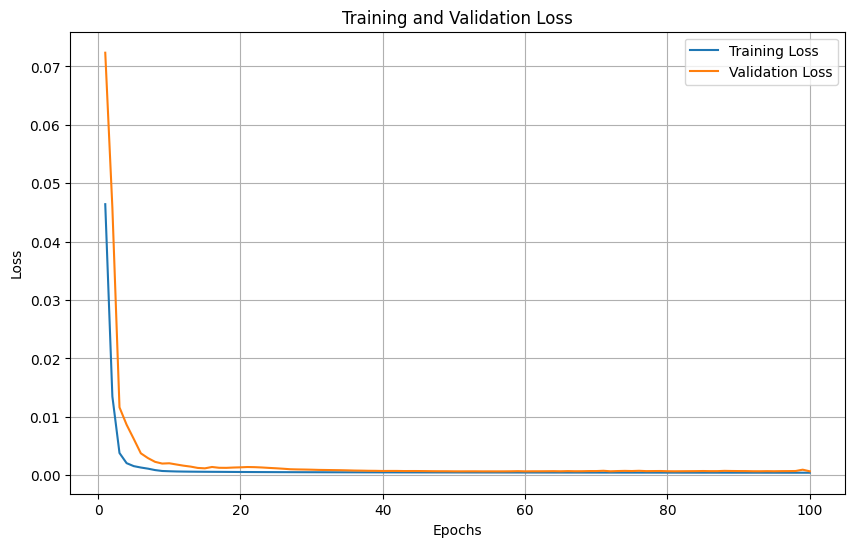

In [ ]:
# 학습 및 검증 손실 저장용 리스트
train_losses = []
val_losses = []

# FineTuning 학습 및 검증
for epoch in range(config_finetuning["num_epochs"]):
    # 훈련 단계
    model_finetuning.train()
    running_loss = 0.0
    for inputs, targets in tqdm(train_loader_finetuning, desc=f"FineTuning Epoch {epoch + 1}/{config_finetuning['num_epochs']}"):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer_finetuning.zero_grad()
        loss = criterion(model_finetuning(inputs), targets)
        loss.backward()
        optimizer_finetuning.step()
        running_loss += loss.item()

    # 검증 단계
    model_finetuning.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader_finetuning:
            inputs, targets = inputs.to(device), targets.to(device)
            loss = criterion(model_finetuning(inputs), targets)
            val_loss += loss.item()

    # 손실 값 기록
    train_loss = running_loss / len(train_loader_finetuning)
    val_loss = val_loss / len(val_loader_finetuning)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # Epoch 결과 출력
    print(f"Epoch {epoch + 1}, Training Loss: {train_loss:.5f}, Validation Loss: {val_loss:.5f}")

# 학습 및 검증 손실 그래프 시각화
plt.figure(figsize=(10, 6))
plt.plot(range(1, config_finetuning["num_epochs"] + 1), train_losses, label="Training Loss")
plt.plot(range(1, config_finetuning["num_epochs"] + 1), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid()
plt.show()

In [ ]:
def inverse_transform(scaler, data, feature_columns_with_target):
    """
    데이터 역정규화 함수
    :param scaler: MinMaxScaler 객체
    :param data: 정규화된 다중 출력 데이터 (numpy 배열, shape: [샘플 수, 출력 수])
    :param feature_columns_with_target: feature와 target column 이름을 포함한 리스트
    :return: target columns의 역정규화된 값 (numpy 배열, shape: [샘플 수, 출력 수])
    """
    num_features = len(feature_columns_with_target)
    full_data = np.zeros((data.shape[0], num_features))  # feature와 target column 크기
    full_data[:, -data.shape[1]:] = data  # 예측된 target columns를 full_data에 맞춰 할당
    inversed = scaler.inverse_transform(full_data)  # 역정규화
    return inversed[:, -data.shape[1]:]  # target columns만 반환


In [ ]:
# 역정규화 함수는 기존 코드와 동일

# 2022년도 테스트 데이터 예측 및 역정규화
model_finetuning.eval()
predictions = []
actuals = []

with torch.no_grad():
    for inputs, targets in val_loader_finetuning:  # 테스트 데이터 로더
        inputs = inputs.to(device)
        output = model_finetuning(inputs).cpu().numpy()
        predictions.append(output)
        actuals.append(targets.cpu().numpy())

# 예측값과 실제값 배열로 변환
predictions = np.concatenate(predictions, axis=0)
actuals = np.concatenate(actuals, axis=0)

# 예측값과 실제값 역정규화
feature_columns_with_target = config_finetuning["feature_columns"] + config_finetuning["target_column"]
predictions_inverse = inverse_transform(finetuning_scaler, predictions, feature_columns_with_target)
actuals_inverse = inverse_transform(finetuning_scaler, actuals, feature_columns_with_target)

# target_column 이름 가져오기
target_columns = config_finetuning["target_column"]

# 칼럼별 RMSE 및 R² 계산
num_targets = len(target_columns)

print("칼럼별 성능 지표:")
rmse_list = []
r2_list = []

for i, column_name in enumerate(target_columns):
    # 각 칼럼의 RMSE 및 R² 계산
    rmse = np.sqrt(mean_squared_error(actuals_inverse[:, i], predictions_inverse[:, i]))
    r2 = r2_score(actuals_inverse[:, i], predictions_inverse[:, i])

    rmse_list.append(rmse)
    r2_list.append(r2)

    print(f"  {column_name}에 대한 역정규화된 RMSE: {rmse:.4f}")
    print(f"  {column_name}에 대한 역정규화된 R²: {r2:.4f}")

# 모든 타겟 통합 RMSE 및 R² 계산
actuals_flattened = actuals_inverse.flatten()
predictions_flattened = predictions_inverse.flatten()

rmse_combined = np.sqrt(mean_squared_error(actuals_flattened, predictions_flattened))
r2_combined = r2_score(actuals_flattened, predictions_flattened)

print("\n통합 성능 지표:")
print(f"  모든 타겟에 대한 역정규화된 통합 RMSE: {rmse_combined:.4f}")
print(f"  모든 타겟에 대한 역정규화된 통합 R²: {r2_combined:.4f}")

칼럼별 성능 지표:
  공급온도1에 대한 역정규화된 RMSE: 0.6716
  공급온도1에 대한 역정규화된 R²: 0.9921
  천창좌개도에 대한 역정규화된 RMSE: 3.2485
  천창좌개도에 대한 역정규화된 R²: 0.9935
  천창우개도에 대한 역정규화된 RMSE: 3.1546
  천창우개도에 대한 역정규화된 R²: 0.9939
  커튼상개도에 대한 역정규화된 RMSE: 2.0604
  커튼상개도에 대한 역정규화된 R²: 0.9979
  커튼하개도에 대한 역정규화된 RMSE: 1.0292
  커튼하개도에 대한 역정규화된 R²: 0.9995
  측커튼개도에 대한 역정규화된 RMSE: 2.6369
  측커튼개도에 대한 역정규화된 R²: 0.9967
  외부커튼개도에 대한 역정규화된 RMSE: 4.4248
  외부커튼개도에 대한 역정규화된 R²: 0.9914
  3Way밸브1개도에 대한 역정규화된 RMSE: 3.8353
  3Way밸브1개도에 대한 역정규화된 R²: 0.9703
  3Way밸브2개도에 대한 역정규화된 RMSE: 3.1882
  3Way밸브2개도에 대한 역정규화된 R²: 0.9927

통합 성능 지표:
  모든 타겟에 대한 역정규화된 통합 RMSE: 2.9376
  모든 타겟에 대한 역정규화된 통합 R²: 0.9955
